# Artyom Iudin BVT2101

In [45]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import itertools
import random
import warnings

tf.get_logger().setLevel('INFO')
warnings.filterwarnings('ignore')

## (a and b) or (a and c)

Необходимо реализовать нейронную сеть вычисляющую результат заданной логической операции. Затем реализовать функции, которые будут симулировать работу построенной модели. Функции должны принимать тензор входных данных и список весов. Должно быть реализовано 2 функции:

Функция, в которой все операции реализованы как поэлементные операции над тензорами

Функция, в которой все операции реализованы с использованием операций над тензорами из NumPy

Для проверки корректности работы функций необходимо:
- Инициализировать модель и получить из нее веса 
- Прогнать датасет через не обученную модель и реализованные 2 функции. Сравнить результат.
- Обучить модель и получить веса после обучения
- Прогнать датасет через обученную модель и реализованные 2 функции. Сравнить результат.

Примечание: так как множество всех наблюдений ограничен, то обучение проводить можно на всем датасете без контроля.

In [46]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

n_vars = 3
values = [0, 1]

# create all possible combinations
combinations = np.array(list(itertools.product(values, repeat=n_vars)))

# repeat them to get data
x = np.repeat(combinations, 10, axis=0)

# compute labels
y = np.logical_or(np.logical_and(x[:, 0], x[:, 1]), np.logical_and(x[:, 0], x[:, 2]))

# shuffle them
order = np.random.permutation(x.shape[0])
x = x[order]
y = y[order]

x[:5], y[:5]

(array([[0, 1, 1],
        [0, 0, 0],
        [0, 1, 0],
        [0, 1, 1],
        [0, 0, 1]]),
 array([False, False, False, False, False]))

In [47]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(1, activation='sigmoid', input_shape=(3,)))

# we need lr large, then default, so initialize model
optimizer = keras.optimizers.Adam(learning_rate=1e-1)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# weights and bias before training
wandb_bt = model.get_weights().copy()
wandb_bt

[array([[ 0.8773805 ],
        [ 0.3983569 ],
        [-0.34608656]], dtype=float32),
 array([0.], dtype=float32)]

In [48]:
def scratch(wandb, x):
    # iterate over features' rows, multiple values on weights, add bias
    # why greater than 0 - look at sigmoid plot
    return [
        (sum(xi * wi for xi, wi in zip(x[i], wandb[0][:, 0])) + wandb[1][0]) > 0 
        for i in range(len(x))
    ]

def np_fn(wandb, x):
    # the same as scratch
    return (x @ wandb[0] + wandb[1]) > 0

sc_predictions = scratch(wandb_bt, x)

# calculate how many times we predicted and devide by number of labels
print("Scratch", sum(sc_predictions[i] == y[i] for i in range(len(sc_predictions))) / y.shape[0])
print("NumPy", np.sum(np_fn(wandb_bt, x)[:, 0] == y) / y.shape[0])

                                 # no logging         cause sigmoid
print("Keras", ((model.predict(x, verbose=False)[:, 0] > 0.5) == y).sum() / y.shape[0])


Scratch 0.625
NumPy 0.625
Keras 0.625


In [49]:
# store metrics for plot
h = model.fit(x, y, epochs=45, verbose=False)

# weights and bias after training
wandb_at = model.get_weights().copy()

In [50]:
sc_predictions = scratch(wandb_at, x)

print("Scratch", sum(sc_predictions[i] == y[i] for i in range(len(sc_predictions))) / y.shape[0])
print("NumPy", np.sum(np_fn(wandb_at, x)[:, 0] == y) / y.shape[0])
print("Keras", ((model.predict(x, verbose=False)[:, 0] > 0.5) == y).sum() / y.shape[0])

Scratch 1.0
NumPy 1.0
Keras 1.0


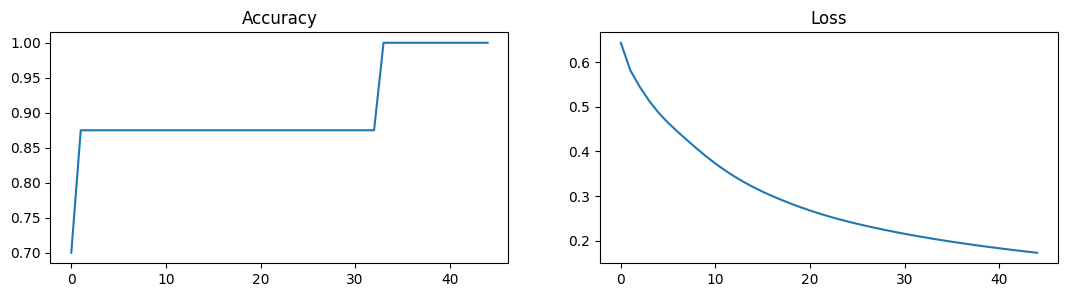

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(13, 3))

ax[0].plot(h.history["accuracy"])
ax[0].set_title("Accuracy")

ax[1].plot(h.history["loss"])
ax[1].set_title("Loss")

plt.show()